In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numba

from my_timer import timer_decorator

# funkcionály optimalizované pro numpy

In [123]:
p, a, b = 3, -1, 1
ne = 20
x = np.linspace(a, b, ne + 1)
h = np.diff(x)


def energy_numpy(v_internal, fx, v, h, p):
    v[1:-1] = v_internal
    vx = (v[1:] - v[:-1]) / h
    v_mid = (v[1:] + v[:-1]) / 2
    Jv_density = (1 / p) * np.abs(vx)**p - fx * v_mid

    return np.sum(h * Jv_density)


# exact minimizer for p=2
def u_init(x):
    return 0 * (x + 1) * (x - 1)


# rhs
def f(x):
    return -10 * np.ones(x.size)


v = u_init(x)            # testing function
v_internal = v[1:-1].copy()

x_mid = (x[1:] + x[:-1]) / 2
fx = f(x_mid)

# minimalizace numpy implementace
cca 3x rychlejší než bez numpy

In [3]:

minimize_timed = timer_decorator(minimize)

print("energy (init)=", energy_numpy(v_internal, fx, v, h, p))


solopt = minimize_timed(energy_numpy, v_internal, args=(fx, v, h, p))

print("energy (final)=", energy_numpy(solopt.x, fx, v, h, p))
print(solopt.nit)

energy (init)= 0.0
minimize#0: 23.090 s
energy (final)= -16.865224260083938
214


# numba
4s vs 7s u mně, tedy asi o 75% rychlejší

In [4]:
from numba import jit, float64, boolean, int64, prange
import numpy as np

@jit(nopython=True)
def energy_numba(v_internal, fx, v, h, p):
    v[1:-1] = v_internal
    n = h.shape[0]
    Jv_density = 0.0
    for i in range(n):
        Jv_density += h[i] * ((1 / p) * np.abs((v[i+1] - v[i]) / h[i])**p - fx [i]* (v[i+1] + v[i]) / 2)
    return Jv_density


In [5]:
print("energy (init)=", energy_numba(v_internal, fx, v, h, p))


solopt = minimize_timed(energy_numba, v_internal, args=(fx, v, h, p))

print("energy (final)=", energy_numba(solopt.x, fx, v, h, p))
print(solopt.nit)

energy (init)= 0.0
minimize#1: 5.791 s
energy (final)= -16.86522425995996
211


# jemnější síť

In [157]:
p, a, b = 3, -1, 1
ne = 500
x = np.linspace(a, b, ne + 1)
h = np.diff(x)

v = u_init(x)            # testing function
v_internal = v[1:-1].copy()

x_mid = (x[1:] + x[:-1]) / 2
fx = f(x_mid)

In [7]:

print("energy (init)=", energy_numpy(v_internal, fx, v, h, p))


solopt = minimize_timed(energy_numpy, v_internal, args=(fx, v, h, p))

print("energy (final)=", energy_numpy(solopt.x, fx, v, h, p))
print(solopt.nit)

energy (init)= 0.0
minimize#2: 39.623 s
energy (final)= -16.865438707319285
507


In [119]:

print("energy (init)=", energy_numba(v_internal, fx, v, h, p))


solopt = minimize(energy_numba, v_internal, args=(fx, v, h, p), method='Powell')

print("energy (final)=", energy_numba(solopt.x, fx, v, h, p))
print(solopt.nit)

energy (init)= 0.0
energy (final)= -8.631211166691951
66


numba byla opět 1.75x rychlejši 47s vs 27s

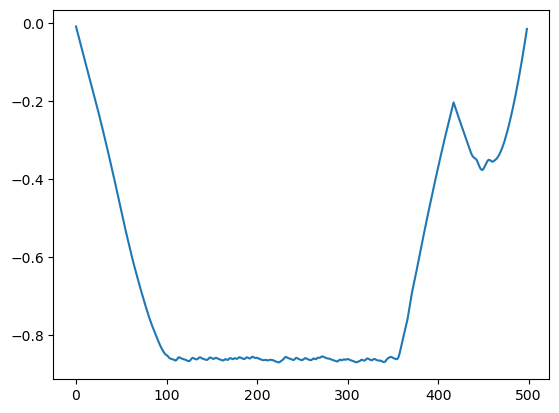

In [120]:
plt.plot(solopt.x)

In [124]:
from my_solvers import trust_region_quasi

fun = lambda x: energy_numpy(x, fx, v, h, p)

solopt,it = trust_region_quasi(fun, v_internal, c0=1,verbose=True)

it=1, f=-1.1656332222197476, c=1, rho=0.1635758343855692, ||g||=34.12515660866823
it=2, f=-1.1656332222197476, c=2, rho=-5.197586137818595, ||g||=34.12515660866823
it=3, f=-1.1656332222197476, c=4, rho=-1.8065924128643194, ||g||=34.12515660866823
it=4, f=-1.1656332222197476, c=8, rho=-0.5538227723410627, ||g||=34.12515660866823
it=5, f=-1.1656332222197476, c=16, rho=-0.007690029988838087, ||g||=34.12515660866823
it=6, f=-4.755822643552118, c=16, rho=0.30917483154474135, ||g||=33.08798617039494
it=7, f=-4.755822643552118, c=32, rho=-0.6541391316724541, ||g||=33.08798617039494
it=8, f=-7.112611732943941, c=32, rho=0.2818040562096497, ||g||=20.09711655012581
it=9, f=-7.869738926643834, c=32, rho=0.1534664694830706, ||g||=13.920791333651062
it=10, f=-9.027564698645392, c=32, rho=0.49648568267318677, ||g||=7.774869078194456
it=11, f=-9.64587221961099, c=16.0, rho=0.942262519344788, ||g||=3.5256275630449267
it=12, f=-10.26437555580255, c=8.0, rho=0.8658703916181609, ||g||=3.520154767309646
i

In [112]:
import numpy
np = numpy

def zlatyrez(f, a, b, x, ddd, tol):
    gamma = 1/2 + numpy.sqrt(5)/2
    a0 = a
    b0 = b
    d0 = (b0-a0)/gamma + a0
    c0 = a0 + b0 - d0
    it = 0
    an = a0
    bn = b0
    cn = c0
    dn = d0
    fcn = f(x + cn * ddd)
    fdn = f(x + dn * ddd)

    while bn - an > tol:
        a = an
        b = bn
        c = cn
        d = dn
        fc = fcn
        fd = fdn

        if fc < fd:
            an = a
            bn = d
            dn = c
            cn = an + bn - dn
            fcn = f(x + cn * ddd)
            fdn = fc
        else:
            an = c
            bn = b
            cn = d
            dn = an + bn - cn
            fcn = fd
            fdn = f(x + dn * ddd)

        it += 1

    t = (an + bn) / 2
    return t, it


from scipy.ndimage import gaussian_filter1d



def quasi_newton(f, x0, tolf=1e-6, tolg=1e-3, h_diff=1e-9, maxit=1000):
    """
    Quasi-Newton method for function minimization

    Parameters
    ----------
    f : function
        The objective function to be minimized.
    x0 : numpy.ndarray
        The initial guess for the minimum.
    tolf : float
        The tolerance for the stopping condition for function values.
    tolg : float
        The tolerance for the stopping condition for gradient values.
    h_diff : float
        The difference used in the finite difference approximation for the gradient.
    maxit : int
        The maximum number of iterations.

    Returns
    -------
    x : numpy.ndarray
        The found minimum.
    it : int
        The number of iterations.
    """

    def df(xx):
        x = np.array(xx)
        n = len(x)
        df_array = np.zeros(n)
        fx = f(x)
        for i in range(n):
            x[i] += h_diff
            df_array[i] = (f(x) - fx) / h_diff
            x[i] -= h_diff
        return df_array

    x = x0
    fx = f(x)
    g = df(x)
    H = np.eye(len(x))  # Start with the identity matrix
    t0 = 1000
    it = 0
    while np.linalg.norm(g) > tolg:
        # Quasi-Newton step
        h = -np.linalg.solve(H, g)

        def g_2D(v):
            a, b = v
            return f(x + a*g + b*h)

        initial_guess = [0, 0]

        result = minimize(g_2D, initial_guess, method='SLSQP')

        a, b = result.x

        # Update x and function value
        s = h
        x = x + a*g + b*h
        fxn = f(x)

        # check stopping condition for f
        if np.abs(fx - fxn) < tolf:
            print("Stopping condition for f is satisfied")
            break

        tmp = df(x)
        y = tmp - g
        # BFGS update
        H = H - np.outer(H @ s, s @ H) / (s @ H @ s) + np.outer(y, y) / (y @ s)

        fx = fxn
        g = tmp

        it += 1
        print(f"it={it}, f={fx}, ||g||={np.linalg.norm(g)}, a={a}, b={b}")

        if it > maxit:
            print("Maximum number of iterations reached")
            break
    else:
        print("Stopping condition for g is satisfied")

    return x, it

In [113]:
fun = lambda x: energy_numpy(x, fx, v, h, p)

solopt,it = quasi_newton(fun, v_internal)

it=1, f=-0.1681490963475386, ||g||=14.083915957388697, a=-0.15794671528129378, b=0.15794647962217032
it=2, f=-0.335287989088543, ||g||=14.057054250253769, a=-5.064747032681295e-07, b=0.0012643931557862387
it=3, f=-0.5014193362600585, ||g||=13.997252919496416, a=8.389176008831157e-07, b=0.001268131745855473
it=4, f=-0.6665441513011212, ||g||=13.939643727477588, a=6.657134817091562e-07, b=0.0012704602480479426
it=5, f=-0.8306660272881905, ||g||=13.880974259629806, a=6.003485912173044e-07, b=0.0012728692341540556
it=6, f=-0.9937853855839891, ||g||=13.82029402130295, a=4.874613653151517e-07, b=0.001275142288199122
it=7, f=-1.1559059056239942, ||g||=13.739356121220386, a=1.5168850984480014e-06, b=0.0012776438137858243
it=8, f=-1.3170273691509002, ||g||=13.68606506390129, a=4.597331570187488e-07, b=0.001279328612733907
it=9, f=-1.4771553663293462, ||g||=13.632686031236132, a=4.939284643054727e-07, b=0.0012821607678993976
it=10, f=-1.6362876041505539, ||g||=13.577726041049818, a=4.41134997993

In [177]:
def cross_entropy_min(f,x0,n_samples=10000, best_percentage=0.001, n_iter=100,sigma=1):
    x = x0.copy()
    sigma_vec = np.ones_like(x0)*sigma
    for i in range(n_iter):
        x_prop = sigma_vec[None,:]*np.random.normal(0,1,(n_samples,len(x0)))+x[None,:]
        y = np.zeros_like(x_prop[:,0])
        for idx, x_i in enumerate(x_prop):
            y[idx] = f(x_i)

        # find indexes of best_percentage of lowest y values
        idx = np.argsort(y)[:int(n_samples*best_percentage)]
        # weighted mean of x_prop with weights -y
        x = np.average(x_prop[idx,:],axis=0)
        # weighted std of x_prop with weights -y
        sigma_vec = (sigma_vec*0.95 + 0.05*np.sqrt(np.average((x_prop[idx,:]-x)**2,axis=0)))
        # set x as min of y in x_prop
        x = x_prop[np.argmin(y),:]
        print(f"it={i}, f={f(x)}, sigma={np.min(sigma_vec)}")
    return x

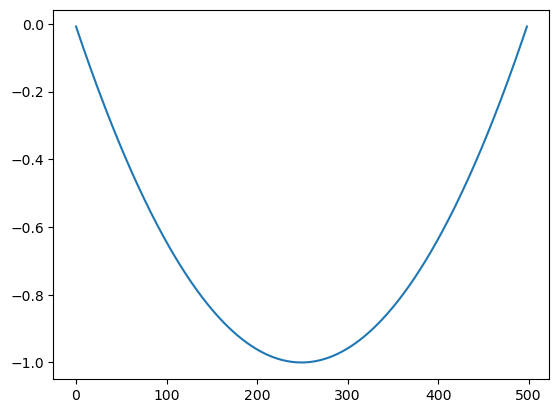

In [189]:
plt.plot(x[1:-1]**2-1)


In [193]:
res = cross_entropy_min(fun, (x[1:-1]**2-1)*2, n_iter=100, sigma=0.1)

it=0, f=27666.951311078898, sigma=0.09651071004932348
it=1, f=69553.29850300816, sigma=0.09473621389830858
it=2, f=108232.06043250253, sigma=0.09398918050331093
it=3, f=148455.23824150028, sigma=0.09272422349024444
it=4, f=172923.13846722193, sigma=0.09098379487214699
it=5, f=206271.90657357773, sigma=0.08964236222657242
it=6, f=247644.4053673571, sigma=0.08890306631779331
it=7, f=274113.1207138607, sigma=0.08761107018447478
it=8, f=302046.02217131737, sigma=0.0869651900055053
it=9, f=324563.12618663703, sigma=0.08566465927153967
it=10, f=343113.03367298015, sigma=0.0837153717787174
it=11, f=356050.9467541514, sigma=0.08261382261551455
it=12, f=367567.5169433709, sigma=0.08160652159744454
it=13, f=384385.39848979685, sigma=0.081778620106123
it=14, f=397884.18450770027, sigma=0.08180513744845355
it=15, f=413416.44582173, sigma=0.08142500108535031
it=16, f=419854.13672928076, sigma=0.08083171908545862
it=17, f=421845.2883872219, sigma=0.07984735279579343
it=18, f=421114.2169322514, sigma

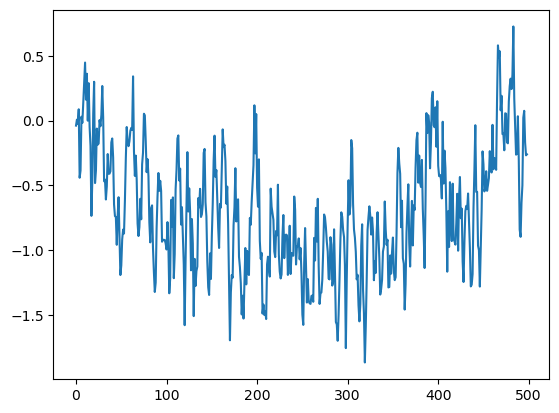

In [192]:
plt.plot(res)
